In [7]:
from tardis import run_tardis
import networkx as nx
from IPython.display import Image, display
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u

In [8]:
sim = run_tardis("../tardis_example.yml",
                 virtual_packet_logging=True,
                 show_convergence_plots=False,
                 export_convergence_plots=False,
                 log_level="ERROR")

Embedding the final state for Jupyter environments


In [9]:
spectrum = sim.spectrum_solver.spectrum_real_packets
spectrum_virtual = sim.spectrum_solver.spectrum_virtual_packets
spectrum_integrated = sim.spectrum_solver.spectrum_integrated

[py.warnings         ][WARNING]  /home/clyde/miniforge3/envs/tardis-installation-test/lib/python3.13/site-packages/astropy/units/format/generic.py:507: UnitsWarning:

'erg/s/Hz' contains multiple slashes, which is discouraged by the FITS standard

 (warnings.py:110)


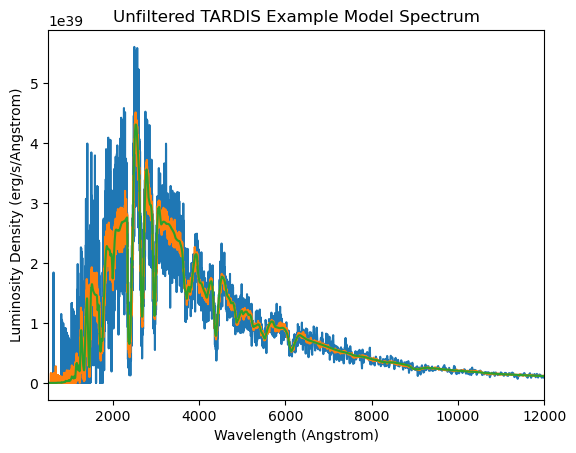

In [25]:
plt.plot(spectrum.wavelength, spectrum.luminosity_density_lambda)
plt.plot(spectrum.wavelength, spectrum_virtual.luminosity_density_lambda)
plt.plot(spectrum.wavelength, spectrum_integrated.luminosity_density_lambda)
plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Luminosity Density (erg/s/Angstrom)")
plt.xlim(500, 12000)
plt.title("Unfiltered TARDIS Example Model Spectrum")
plt.show()

In [26]:
import requests
import yaml

# Function to get Filter URL from TARDIS config file
def get_url_from_config(config_file_path):
    with open(config_file_path, 'r') as f:
        url = yaml.safe_load(f)['filter']['VOTable_download_url']
    return url

downloadUrl = get_url_from_config('filter_url.yml')

In [27]:
def download_filter(url, filename):
    req = requests.get(url)
    
    # Check if filename is provided
    if filename:
        pass
    else:
        # Set filename from URL and change any '/' to '.' to avoid directory issues
        filename = req.url[downloadUrl.rfind('ID=')+3:].replace('/', '.')

    with open((f'Filters/{filename}.xml'), 'wb') as f:
            
        # Chunking to avoid large memory consumption
        for chunk in req.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)
        
        return filename
    
chosen_filter = download_filter(downloadUrl, None)

In [28]:
import xml.etree.ElementTree as et

def get_filter(filter_name):
    
    # Parse XML File from Filters Directory
    # This will have to be changed when we switch to grabbing from online database 
    root = et.parse(f"Filters/{filter_name}.xml")
    
    # Get wavelength and transmission values in one array (Will be in aleternating order)
    all_vals = np.array([float(x.text) for x in root.findall('.//TD')])

    # Separate wavelength and transmission values
    wl = all_vals[0::2] * u.AA
    tr = all_vals[1::2]

    # Interpolate spectrum wavelengths with filter wavelengths to find matching transmission values
    return np.interp(spectrum.wavelength, wl, tr)

TS_filter = get_filter(chosen_filter)

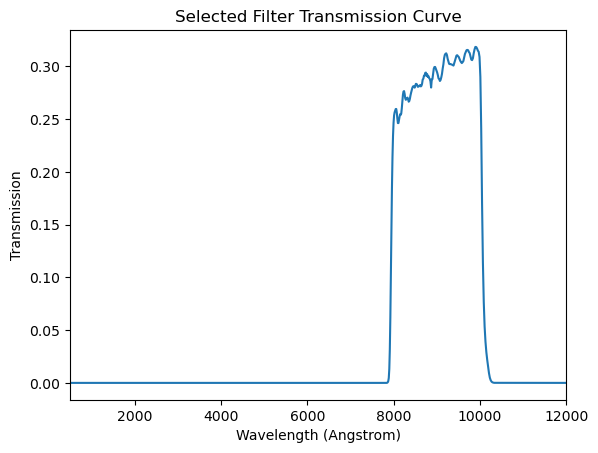

In [29]:
plt.plot(spectrum.wavelength, TS_filter)
plt.title("Selected Filter Transmission Curve")
plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Transmission")
plt.xlim(500, 12000)
plt.show()

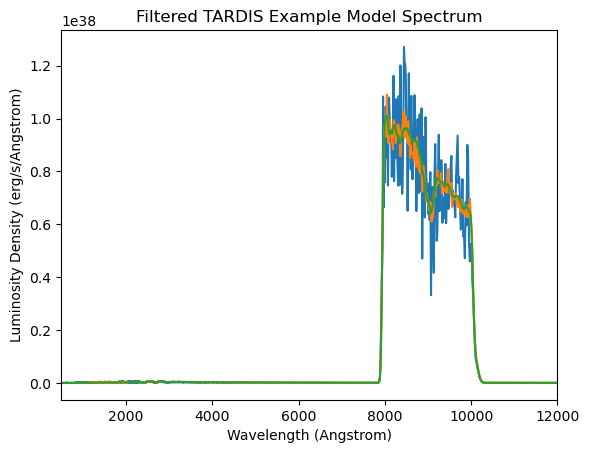

In [30]:
plt.plot(spectrum.wavelength, spectrum.luminosity_density_lambda * TS_filter)
plt.plot(spectrum.wavelength, spectrum_virtual.luminosity_density_lambda * TS_filter)
plt.plot(spectrum.wavelength, spectrum_integrated.luminosity_density_lambda * TS_filter)
plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Luminosity Density (erg/s/Angstrom)")
plt.xlim(500, 12000)
plt.title("Filtered TARDIS Example Model Spectrum")
plt.show()